In [1]:
%run ./setup_notebook.ipynb

In [2]:
import pickle
from matplotlib import patches
from subsets_analysis import Subsets
import utils.utils_funcs as uf
from scipy.signal import butter, lfilter, freqz, filtfilt
from opto_stim_import2 import OptoStimBasic

%matplotlib inline

In [122]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
    
]

mice_dicts = [
            {'mouse_id': 'J065', 'run_numbers': [14], 'runs': []} ] 

In [123]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [124]:
run = mice_dicts[0]['runs'][0]

In [125]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'reloaded', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path'])

In [126]:
def my_floor(a, precision=0):
    # Floors to a specified number of dps
    return np.round(a - 0.5 * 10**(-precision), precision)

def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

In [127]:
run.tseries_paths

['/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-003',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-004',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-005',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-006',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-007',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-008',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-009',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-010',
 '/home/jrowland/mnt/qnap/Data/2019-12-17/2019-12-17_J065_t-011']

In [133]:
def non_zero_smoother(arr, window_size=200):
    
    """ Smooths an array by changing values to the number of
        non-0 elements with window
        
        """
    
    windows = np.arange(0, len(arr), window_size)
    windows = np.append(windows, len(arr))

    for idx in range(len(windows)):

        chunk_start = windows[idx]
        
        if idx == len(windows) - 1:
            chunk_end = len(arr)
        else:
            chunk_end = windows[idx+1]
            
        arr[chunk_start:chunk_end] = np.count_nonzero(arr[chunk_start:chunk_end])
    
    return arr

In [129]:
def get_spiral_start(x_galvo, debounce_time):
    
    """ Get the sample at which the first spiral in a trial began 
    
    Function involving lots of magic numbers
    to detect spiral onsets.
    Failures should be caught by assertion at end
    Inputs:
    x_galvo -- x_galvo signal recorded in paqio
    debouce_time -- length of time (samples) encapulsating a whole trial
                    ensures only spiral at start of trial is captured
                    
    n.b. function is inefficient and heavily hand-tuned so may break
         a better version of this would be some form of template
         matching at a known galvo spiral voltage signal
    
    """
    # Filter noise by flooring the signal to 2dp
    x_galvo = my_floor(x_galvo, 2)
    
    # Threshold above which to determine signal as onset of square pulse
    square_thresh = 0.02
    # Threshold above which to consider signal a spiral (empirically determined)
    diff_thresh = 10
    
    # remove noise from parked galvo signal
    x_galvo[x_galvo < -0.5] = -0.6
    
    # Approximate first order differential of galvo signal
    diffed = np.diff(x_galvo)
    # remove the onset of galvo movement from f' signal
    diffed[diffed > square_thresh] = 0
    # Smooth based on nonzero entries
    diffed = non_zero_smoother(diffed, window_size=200)
    # Lots of noise just before stim can get captured as spiral
    # filter this out
    diffed[diffed>30] = 0
    
    # detect onset of sprials
    spiral_start = uf.threshold_detect(diffed, diff_thresh)
    
    if len(spiral_start) == 0:
        print('No spirals found')
        return None
    else:
        # Debounce to remove spirals that are not the onset of the trial
        spiral_start = spiral_start[np.hstack((np.inf, np.diff(spiral_start))) > debounce_time]
        n_squares = len(uf.threshold_detect(x_galvo, -0.5))
        assert len(spiral_start) == n_squares, \
        'spiral_start has len {} but there are {} square pulses'.format(len(spiral_start), n_squares)
        return spiral_start

In [130]:
def get_trial_frames(clock, start, pre_frames, post_frames, fs=30):

    # The frames immediately preceeding stim
    frame_idx = uf.closest_frame_before(clock, start)
    trial_frames = np.arange(frame_idx-pre_frames, frame_idx+post_frames)
    
    # Is the trial outside of the frame clock
    is_beyond_clock = np.max(trial_frames) >= len(clock) or np.min(trial_frames) < 0
    
    if is_beyond_clock:
        return None
    
    frame_to_start = (start - clock[frame_idx]) / run.paq_rate  # time (s) from frame to trial_start
    frame_time_diff = np.diff(clock[trial_frames]) / run.paq_rate  # ifi (s)
    
    # did the function find the correct frame
    is_not_correct_frame = clock[frame_idx+1]  < start or clock[frame_idx] > start
    # the nearest frame to trial start was not during trial
    # if the time to the nearest frame is less than upper bound of inter-frame-interval
    trial_not_running = frame_to_start > 1/(fs-1)
    frames_not_consecutive = np.max(frame_time_diff) > 1/(fs-1)
    
    if trial_not_running or frames_not_consecutive:
        return None
    
    # Just return the start of trial frame
    return frame_idx
    
    return trial_frames

In [131]:
paqio_frames = uf.tseries_finder(run.num_frames, run.frame_clock)
trial_start = get_spiral_start(run.x_galvo_uncaging, run.paq_rate*6)

bad_frames = []
for i, start in enumerate(trial_start):
    
    trial_frames = get_trial_frames(paqio_frames, start, 2, 2, fs=30)
    bad_frames.append(trial_frames)

# stack overflow flatten list of lists
#bad_frames = [item for sublist in bad_frames for item in sublist]

In [132]:
for frame, subset in zip(bad_frames, Subsets(run).trial_subsets):
    if frame is None:
        print(None)
    else:
        print(frame - run.num_frames[0])
        
    print(subset)
    print('\n')

133
150


2097
10


3751
50


7475
40


9399
150


10703
0


11915
0


12422
0


12898
10


13639
150


17330
50


17943
150


18974
150


19487
0


20070
150


21218
150


24820
0


26523
10


27240
0


28068
150


29862
150


30997
0


33089
150


33580
150


34275
50


35509
0


38315
150


39041
50


41920
150


46526
30


None
150


48051
0


48410
150


50297
30


52631
150


54975
0


55753
10


56746
150


58247
20


60000
150


61680
10


63326
30


64723
150


68427
0


68921
10


69433
0


70265
150


73061
0


73511
150


75657
150


77337
0


77949
0


78473
150


79354
20


81142
150


83533
150


86101
150


88425
0


88894
0


89672
0


90018
150


91010
150


91424
150


93093
30


94349
0


95125
10


96103
0


96442
0


96751
5


97516
5


98213
0


99327
150


100515
150


100903
50


101769
40


102554
5


102908
0


103783
10


104531
0


104832
10


105181
150


105549
40


107661
0


None
0


107984
0


108587
150


109342
40


110008
10


111032
150


112368
15

In [104]:
def get_spiral_start(x_galvo, debounce_time):
    
    """ Get the sample at which the first spiral in a trial began 
    
    Experimental function involving lots of magic numbers
    to detect spiral onsets.
    Failures should be caught by assertion at end
    Inputs:
    x_galvo -- x_galvo signal recorded in paqio
    debouce_time -- length of time (samples) encapulsating a whole trial
                    ensures only spiral at start of trial is captured
    
    """
    #x_galvo = np.round(x_galvo, 2)
    x_galvo = my_floor(x_galvo, 2)
    
    # Threshold above which to determine signal as onset of square pulse
    square_thresh = 0.02
    # Threshold above which to consider signal a spiral (empirically determined)
    diff_thresh = 10
    
    # remove noise from parked galvo signal
    x_galvo[x_galvo < -0.5] = -0.6
    
    global diffed
    diffed = np.diff(x_galvo)
    # remove the onset of galvo movement from f' signal
    diffed[diffed > square_thresh] = 0
    diffed = non_zero_smoother(diffed, window_size=200)
    diffed[diffed>30] = 0
    
    # detect onset of sprials
    spiral_start = uf.threshold_detect(diffed, diff_thresh)
    
    if len(spiral_start) == 0:
        print('No spirals found')
        return None
    else:
        # Debounce to remove spirals that are not the onset of the trial
        spiral_start = spiral_start[np.hstack((np.inf, np.diff(spiral_start))) > debounce_time]
        n_squares = len(uf.threshold_detect(x_galvo, -0.5))
        assert len(spiral_start) == n_squares, \
        'spiral_start has len {} but there are {} square pulses'.format(len(spiral_start), n_squares)
        return spiral_start, x_galvo

In [86]:
spiral_start, x_galvo = get_spiral_start(run.x_galvo_uncaging, run.paq_rate*6)

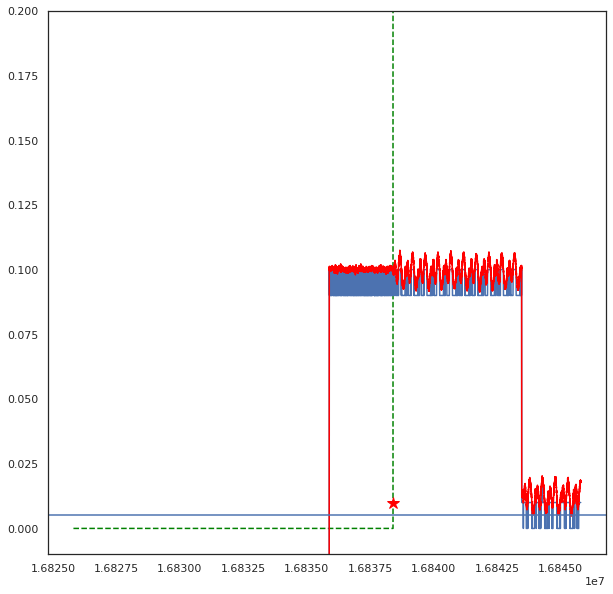

In [88]:
trial_num = 3
plt.figure(figsize=(10,10))

start_fig = trial_start[trial_num]-10000
end_fig = trial_start[trial_num]+10000

snip_idx = np.arange(start_fig, end_fig)

snip_raster = lambda arr: arr[(arr>start_fig) & (arr<end_fig)]

plt.plot(snip_idx, diffed[snip_idx] , '--', color='green')

uf.raster_plot(snip_raster(spiral_start), y_pos=0.01, marker='*', color='red')
plt.plot(snip_idx, x_galvo[snip_idx])
plt.plot(snip_idx, run.x_galvo_uncaging[snip_idx], color='red')
uf.raster_plot(snip_raster(paqio_frames), y_pos=10)
plt.plot()
plt.ylim(-0.01,0.2)
plt.axhline(0.005)